1. Forecasting at Scale paper: https://peerj.com/preprints/3190.pdf 
2. Prophet documentation: https://facebook.github.io/prophet/docs/quick_start.html

## Installation

In [33]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.make_holidays import make_holidays_df

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Importing Dataset

In [35]:
df = pd.read_csv('Items Shipped.csv')

In [36]:
# converting ship date to pandas datetime
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

# filtering to the desired item
item = '5017'
filtered_df = df[(df['Item'] == item) & (df['Import/Domestic'] == 'Domestic')]
# # grouping quantity to frequency of month
new_df = filtered_df.groupby(pd.Grouper(key='Ship Date', freq="M"))['Quantity'].sum().reset_index()
new_df.set_index('Ship Date', inplace=True)
new_df.tail()

,Quantity
Ship Date,
2024-01-31,38985.0
2024-02-29,41548.0
2024-03-31,57447.0
2024-04-30,105693.0
2024-05-31,55474.0


I wonder if removing the data for the month of May would help the model because it isn't a full month so it might be dropping the forecast to much

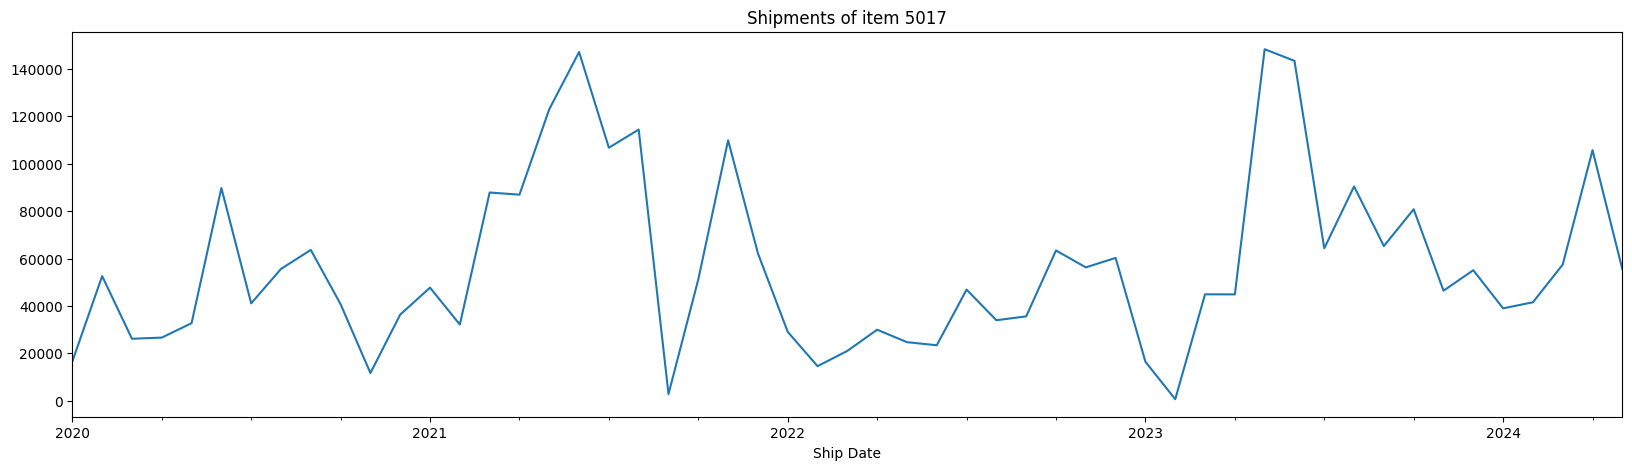

In [37]:
# plotting the sales of store 1 
new_df['Quantity'].plot(figsize=(20,5))
plt.title(f'Shipments of item {item}')
plt.show()


### Preparing data for prophet
The input to Prophet is always a dataframe with two columns: **ds** and **y**. 

- The **ds** (datestamp) column should be of a format expected by Pandas, ideally **YYYY-MM-DD** for a date or **YYYY-MM-DD HH:MM:SS** for a timestamp. 
- The y column must be numeric, and represents the measurement we wish to forecast.

In [38]:
# we can sort the store1 index into chronological order
df_prophet = new_df.reset_index()[['Ship Date', 'Quantity']].rename({'Ship Date':'ds', 'Quantity':'y'}, axis='columns')
df_prophet.head(10)

,ds,y
0,2020-01-31,16593.0
1,2020-02-29,52589.0
2,2020-03-31,26165.0
3,2020-04-30,26650.0
4,2020-05-31,32738.0
5,2020-06-30,89728.0
6,2020-07-31,41078.0
7,2020-08-31,55610.0
8,2020-09-30,63622.0
9,2020-10-31,40718.0


Note: Due to it's non-recursive nature (the only regressor is time), Prophet can handle missing data easily, we don't need to interpolate values for store close dates. We can simply remove them from the data!

In [39]:
df_prophet.tail()

,ds,y
48,2024-01-31,38985.0
49,2024-02-29,41548.0
50,2024-03-31,57447.0
51,2024-04-30,105693.0
52,2024-05-31,55474.0


## Prophet Base Model

In [40]:
m1 = Prophet() # uses default values
m1.fit(df_prophet)

14:42:09 - cmdstanpy - INFO - Chain [1] start processing
14:42:10 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
future = m1.make_future_dataframe(periods=3, freq='M')
future.tail()

,ds
51,2024-04-30
52,2024-05-31
53,2024-06-30
54,2024-07-31
55,2024-08-31


In [42]:
forecast = m1.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
51,2024-04-30,71577.308168,39442.904575,113516.329147,71577.308168,71577.308168,5426.465236,5426.465236,5426.465236,5426.465236,5426.465236,5426.465236,0.0,0.0,0.0,77003.773404
52,2024-05-31,71923.235219,23309.879968,94012.995939,71923.235219,71923.235219,-13894.459932,-13894.459932,-13894.459932,-13894.459932,-13894.459932,-13894.459932,0.0,0.0,0.0,58028.775287
53,2024-06-30,72258.003332,78495.539865,150081.626732,72258.003313,72258.003353,41684.809036,41684.809036,41684.809036,41684.809036,41684.809036,41684.809036,0.0,0.0,0.0,113942.812368
54,2024-07-31,72603.930383,48118.642859,121351.095293,72603.930319,72603.930449,12457.578526,12457.578526,12457.578526,12457.578526,12457.578526,12457.578526,0.0,0.0,0.0,85061.508909
55,2024-08-31,72949.857434,57817.525568,127948.904275,72949.857299,72949.857568,20671.017173,20671.017173,20671.017173,20671.017173,20671.017173,20671.017173,0.0,0.0,0.0,93620.874607


**yhat**: The final forecasted value, which is the sum of the trend and additive_terms (seasonal components + holida effects), plus any multiplicative adjustments if applicable

In [43]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
51,2024-04-30,77003.773404,39442.904575,113516.329147
52,2024-05-31,58028.775287,23309.879968,94012.995939
53,2024-06-30,113942.812368,78495.539865,150081.626732
54,2024-07-31,85061.508909,48118.642859,121351.095293
55,2024-08-31,93620.874607,57817.525568,127948.904275


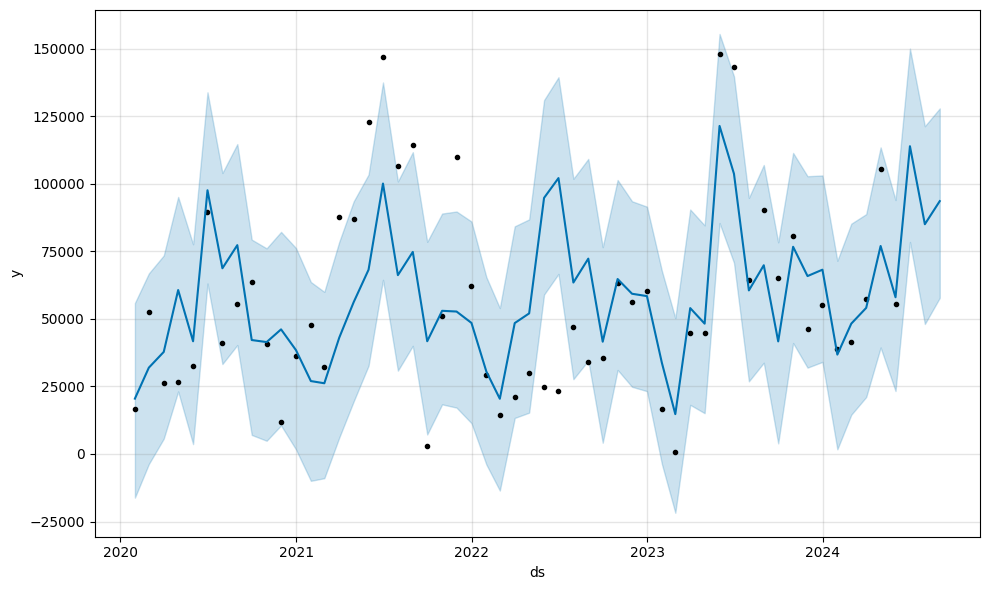

In [44]:
fig1 = m1.plot(forecast)

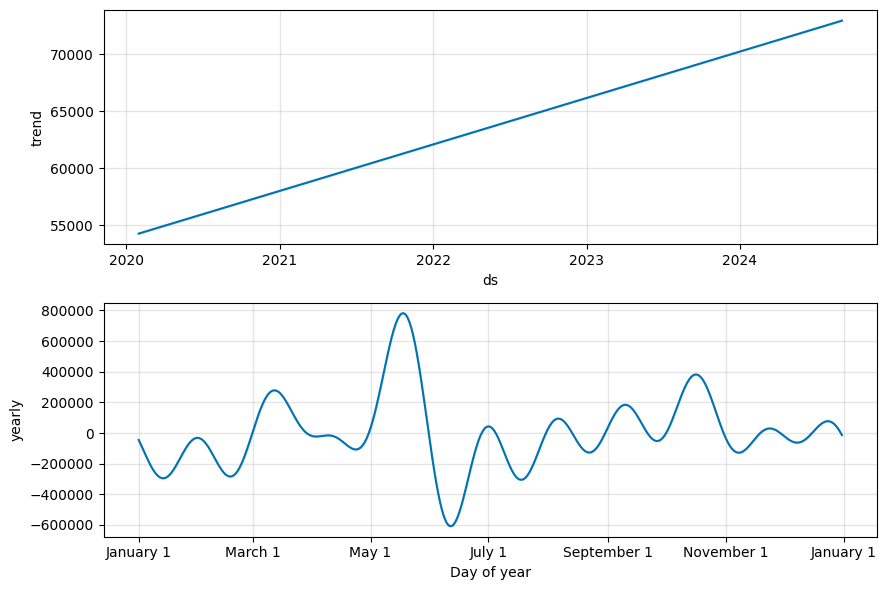

In [45]:
fig1_c = m1.plot_components(forecast)

## Prophet Custom Model

In [46]:
# Adding custom holidays
holidays = pd.DataFrame({
    'holiday': ['christmas', 'fathers_day'] * 5,
    'ds': pd.to_datetime([
        '2020-12-25', '2020-06-21',
        '2021-12-25', '2021-06-20',
        '2022-12-25', '2022-06-19',
        '2023-12-25', '2023-06-18',
        '2024-12-25', '2024-06-16'
    ]),
    'lower_window': 0,
    'upper_window': 1
})

holidays['ds'] = holidays['ds'].dt.to_period('M').dt.to_timestamp()

In [47]:
m2 = Prophet(changepoint_prior_scale=0.05, changepoint_range=0.8, seasonality_mode='multiplicative', holidays=holidays, seasonality_prior_scale=0.1) # after finding the best parameters, we can set them here. 
# default was 10 for seasonality_prior_scale

#m2.add_country_holidays(country_name='US') # holidays will be ignored if not on the exact date in the dataset i need to figure out how to add them

m2.fit(df_prophet)

14:42:11 - cmdstanpy - INFO - Chain [1] start processing
14:42:11 - cmdstanpy - INFO - Chain [1] done processing


In [48]:
future2 = m2.make_future_dataframe(periods=3, freq='M')
future2.tail()

,ds
51,2024-04-30
52,2024-05-31
53,2024-06-30
54,2024-07-31
55,2024-08-31


In [49]:
# print df_prophet and future2 shapes
print(df_prophet.shape)
print(future2.shape)

(53, 2)
(56, 1)


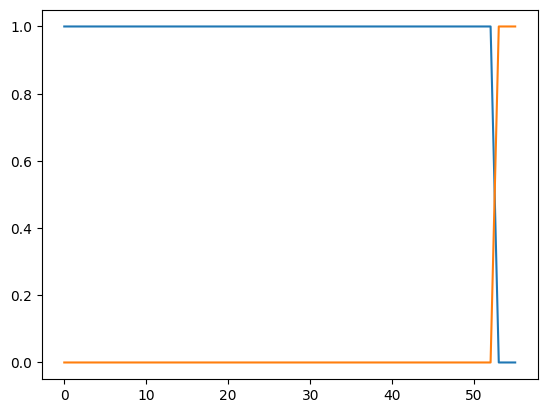

In [50]:
# Let's create a train and forecast index for the future2 dataframe

train_index = future2['ds'].isin(df_prophet['ds'])
forecast_index = ~train_index

# plot the train index and test index to see the split
plt.plot(train_index)
plt.plot(forecast_index)
plt.show()

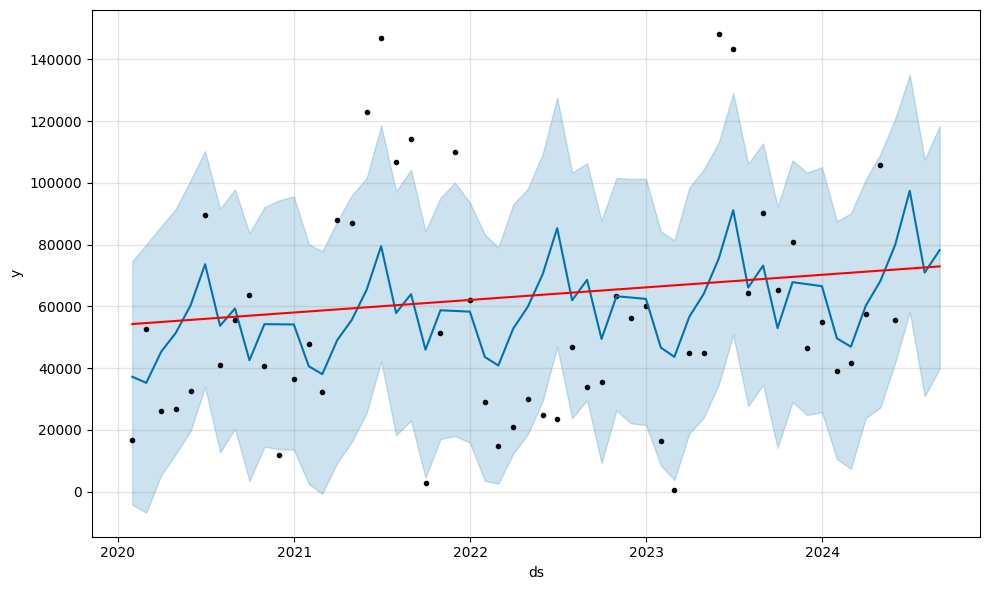

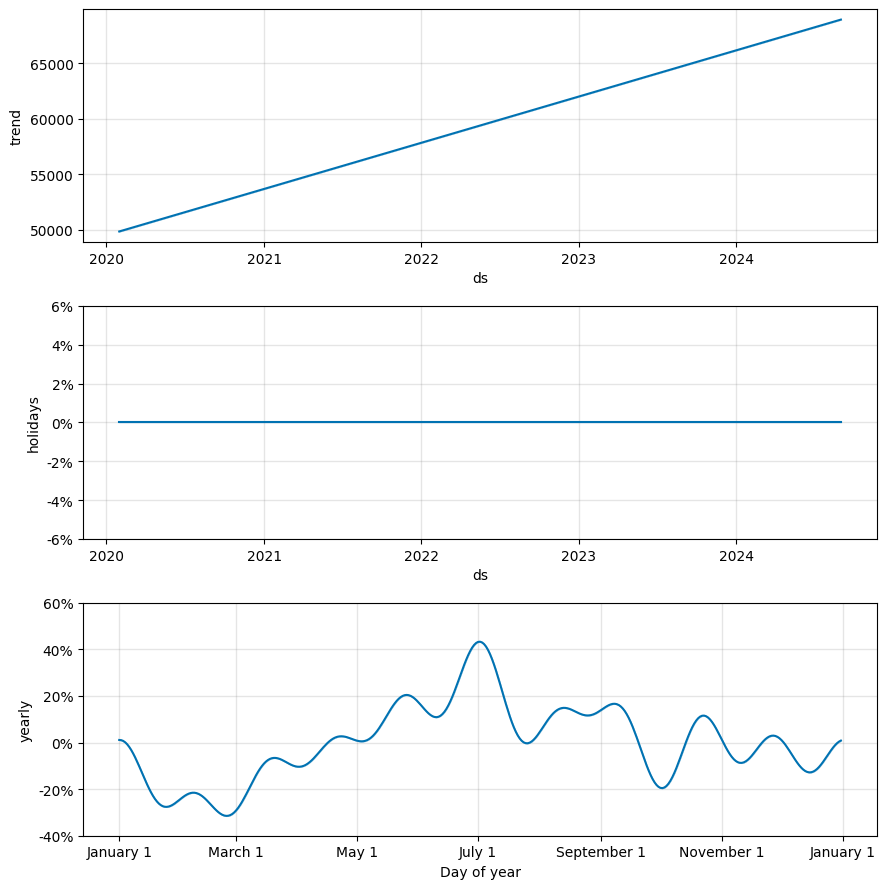

In [51]:
forecast2 = m2.predict(future2)
fig2 = m2.plot(forecast2)
a = add_changepoints_to_plot(fig2.gca(), m2, forecast) # are the changepoints in the right place?

fig2_c = m2.plot_components(forecast2)

In [52]:
m2.train_holiday_names

0      christmas
1    fathers_day
dtype: object

## Model Evaluations & Diagnostics

In [53]:
# Initial 2 years training period
initial = 2 * 365
initial = str(initial) + ' days'

# Roll every 30 days
period = 30
period = str(period) + ' days'

# Forecast 12 weeks into the future
horizon = 90
horizon = str(horizon) + ' days'

print("initial: ", initial)
print("period: ", period)
print("horizon: ", horizon)

initial:  730 days
period:  30 days
horizon:  90 days


In [54]:
df_cv_m2 = cross_validation(m2, initial=initial, period=period, horizon=horizon)

  0%|          | 0/26 [00:00<?, ?it/s]

14:42:12 - cmdstanpy - INFO - Chain [1] start processing
14:42:12 - cmdstanpy - INFO - Chain [1] done processing
14:42:12 - cmdstanpy - INFO - Chain [1] start processing
14:42:12 - cmdstanpy - INFO - Chain [1] done processing
14:42:12 - cmdstanpy - INFO - Chain [1] start processing
14:42:13 - cmdstanpy - INFO - Chain [1] done processing
14:42:13 - cmdstanpy - INFO - Chain [1] start processing
14:42:13 - cmdstanpy - INFO - Chain [1] done processing
14:42:13 - cmdstanpy - INFO - Chain [1] start processing
14:42:13 - cmdstanpy - INFO - Chain [1] done processing
14:42:13 - cmdstanpy - INFO - Chain [1] start processing
14:42:14 - cmdstanpy - INFO - Chain [1] done processing
14:42:14 - cmdstanpy - INFO - Chain [1] start processing
14:42:14 - cmdstanpy - INFO - Chain [1] done processing
14:42:14 - cmdstanpy - INFO - Chain [1] start processing
14:42:14 - cmdstanpy - INFO - Chain [1] done processing
14:42:14 - cmdstanpy - INFO - Chain [1] start processing
14:42:15 - cmdstanpy - INFO - Chain [1]

In [55]:
df_cv_m2

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2022-02-28,93774.811198,64218.498216,121589.297576,14610.0,2022-02-11
1,2022-03-31,116432.626592,86949.987372,145303.993266,21046.0,2022-02-11
2,2022-04-30,110634.538999,81974.408562,138250.978337,29975.0,2022-02-11
3,2022-03-31,109188.357626,75447.334826,139073.169016,21046.0,2022-03-13
4,2022-04-30,103608.210940,71482.178192,137155.239159,29975.0,2022-03-13
...,...,...,...,...,...,...
73,2024-03-31,61087.861689,19493.771839,97577.336992,57447.0,2024-02-01
74,2024-04-30,60185.968182,15907.022138,99713.326489,105693.0,2024-02-01
75,2024-03-31,61009.870519,21899.355929,99418.929343,57447.0,2024-03-02
76,2024-04-30,60111.371118,18051.413261,98334.120378,105693.0,2024-03-02


* cutoff is where we started the forecast from
* ds is the timestamp for the forecasted value

In [56]:
m2_metrics = performance_metrics(df_cv_m2, rolling_window=0.1) # default is 0.1
m2_metrics

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,21 days,3.228734e+09,56821.953989,48846.317045,1.927217,1.985826,0.829146,0.428571
1,22 days,1.176026e+09,34293.235654,25897.240150,9.604741,0.317710,0.642017,0.714286
2,23 days,3.624008e+08,19036.827001,12387.804551,9.085168,0.125250,0.402763,0.857143
3,24 days,2.398619e+09,48975.696642,32761.886748,3.423835,0.248249,0.505236,0.666667
4,25 days,2.305032e+09,48010.746442,30384.320700,0.436029,0.125250,0.404833,0.714286
5,26 days,2.389373e+09,48881.214518,34370.643952,0.481586,0.235915,0.457306,0.714286
6,27 days,1.770038e+09,42071.821095,30523.184148,0.452417,0.235915,0.419547,0.809524
7,28 days,2.820768e+08,16795.142359,14708.718326,0.247353,0.203088,0.229139,1.000000
8,29 days,2.653492e+08,16289.541926,14348.566278,0.269769,0.235915,0.239834,1.000000
9,48 days,2.220338e+09,47120.460273,32947.644640,1.179710,0.355929,0.512687,0.714286


**Important**: Since the Horizon is 42 days, and the default moving average windows is 10% of Horizon (i.e 4 days), the first value starts from 4 days. 
we can change the rolling window like this: *performance_metrics(df_cv, rolling_window=1)*

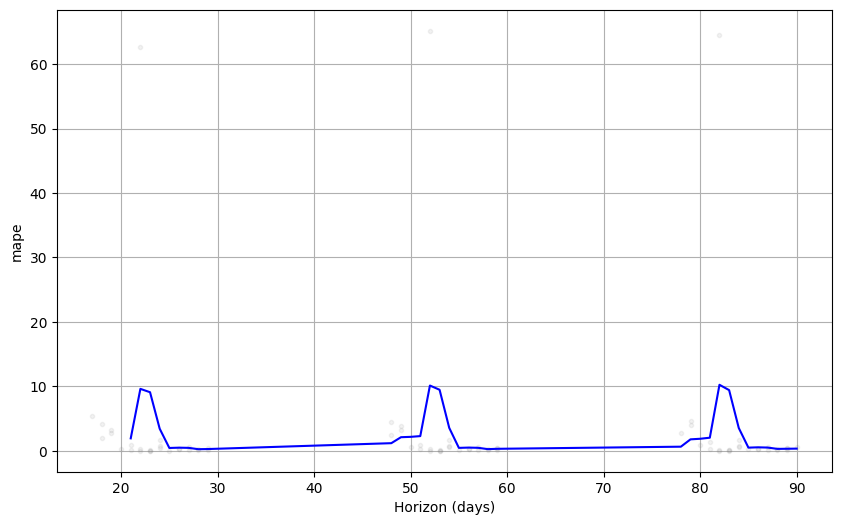

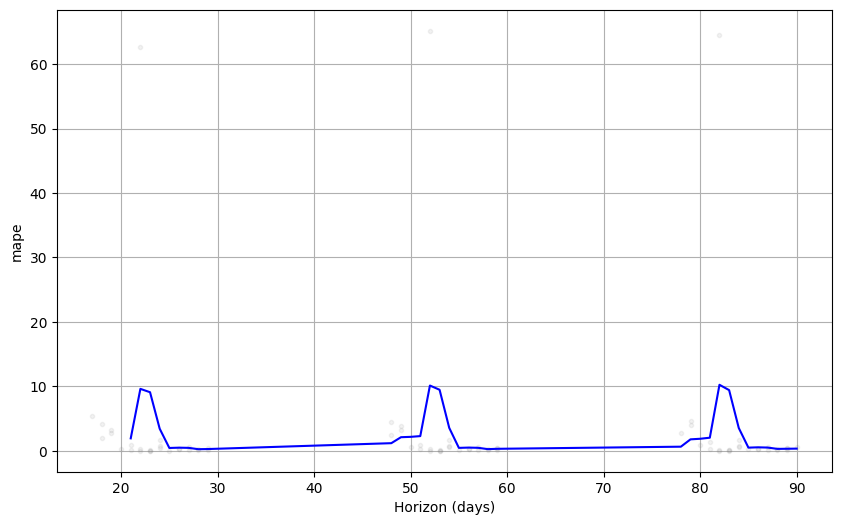

In [57]:
plot_cross_validation_metric(df_cv_m2, metric='mape')

  0%|          | 0/26 [00:00<?, ?it/s]

14:42:21 - cmdstanpy - INFO - Chain [1] start processing
14:42:21 - cmdstanpy - INFO - Chain [1] done processing
14:42:21 - cmdstanpy - INFO - Chain [1] start processing
14:42:21 - cmdstanpy - INFO - Chain [1] done processing
14:42:21 - cmdstanpy - INFO - Chain [1] start processing
14:42:22 - cmdstanpy - INFO - Chain [1] done processing
14:42:22 - cmdstanpy - INFO - Chain [1] start processing
14:42:22 - cmdstanpy - INFO - Chain [1] done processing
14:42:22 - cmdstanpy - INFO - Chain [1] start processing
14:42:22 - cmdstanpy - INFO - Chain [1] done processing
14:42:22 - cmdstanpy - INFO - Chain [1] start processing
14:42:23 - cmdstanpy - INFO - Chain [1] done processing
14:42:23 - cmdstanpy - INFO - Chain [1] start processing
14:42:23 - cmdstanpy - INFO - Chain [1] done processing
14:42:23 - cmdstanpy - INFO - Chain [1] start processing
14:42:23 - cmdstanpy - INFO - Chain [1] done processing
14:42:23 - cmdstanpy - INFO - Chain [1] start processing
14:42:24 - cmdstanpy - INFO - Chain [1]

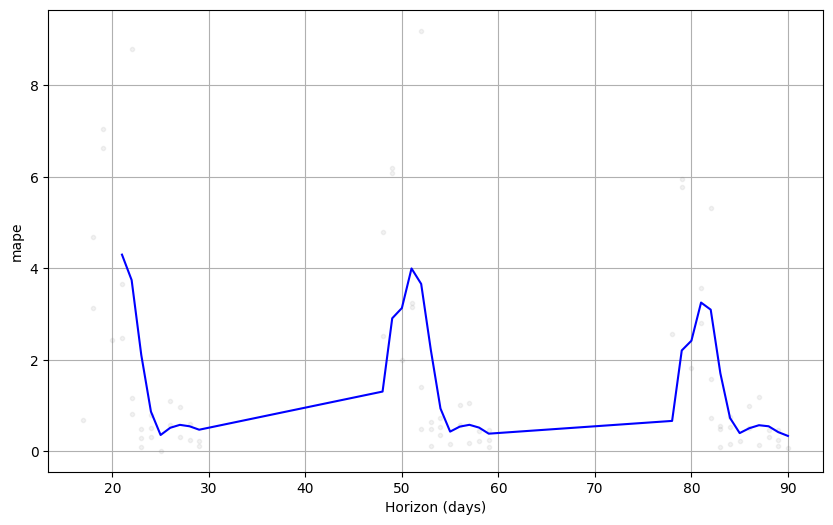

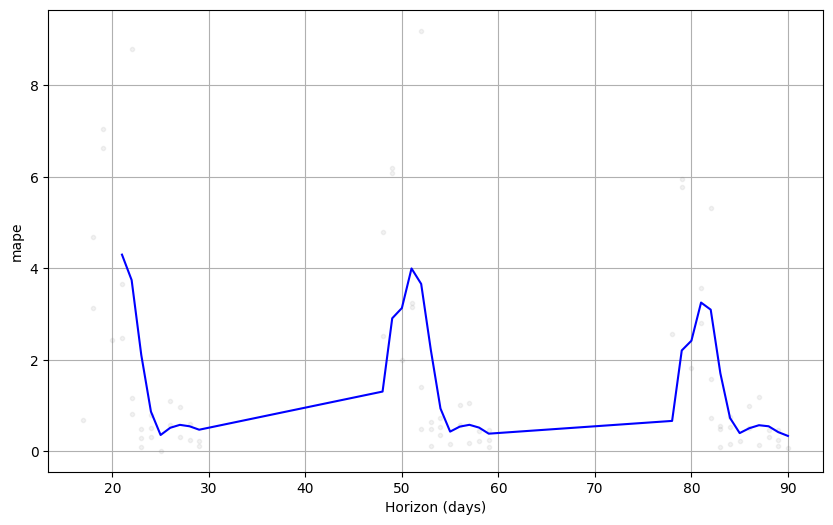

In [58]:
# we can repeat the cross validation for the m1 model
df_cv_m1 = cross_validation(m1, initial=initial, period=period, horizon=horizon)
m1_metrics = performance_metrics(df_cv_m1)
plot_cross_validation_metric(df_cv_m1, metric='mape')

In [59]:
# now we can compare the performance of the two models, m1 without regressors and m2 with regressors
# we can compare the mape, rmse, mse, mae, mdape, smape, coverage, and coverage of the two models
# we can also compare the mean and std of the metrics

model1 = pd.DataFrame(m1_metrics.drop(columns=['horizon']).mean().round(3), columns=['m1_base_model_mean'])
model1['m1_base_model_std'] = pd.DataFrame(m1_metrics.drop(columns=['horizon']).std().round(3))
model1.T


,mse,rmse,mae,mape,mdape,smape,coverage
m1_base_model_mean,4.731869e+09,63741.561,52227.576,1.496,1.102,0.798,0.467
m1_base_model_std,3.877464e+09,26251.690,26065.162,1.292,1.062,0.320,0.214


In [60]:
model2 = pd.DataFrame(m2_metrics.drop(columns=['horizon']).mean().round(3), columns=['m2_custom_model_mean'])
model2['m2_custom_model_std'] = pd.DataFrame(m2_metrics.drop(columns=['horizon']).std().round(3))
model2.T

,mse,rmse,mae,mape,mdape,smape,coverage
m2_custom_model_mean,2.101525e+09,42650.166,32443.178,2.668,0.588,0.517,0.698
m2_custom_model_std,1.421973e+09,17060.153,13975.239,3.430,0.703,0.197,0.203


## Hyper parameter tuning 

Available tunable parameters are [here](https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning)!

In [61]:
import itertools
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the mapes for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_prophet)  # Fit model with given params
    df_cv = cross_validation(m, initial=initial, period=period, horizon=horizon)
    df_p = performance_metrics(df_cv, rolling_window=1)
    mapes.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
print(tuning_results)

14:42:29 - cmdstanpy - INFO - Chain [1] start processing
14:42:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/26 [00:00<?, ?it/s]

14:42:30 - cmdstanpy - INFO - Chain [1] start processing
14:42:30 - cmdstanpy - INFO - Chain [1] done processing
14:42:30 - cmdstanpy - INFO - Chain [1] start processing
14:42:30 - cmdstanpy - INFO - Chain [1] done processing
14:42:30 - cmdstanpy - INFO - Chain [1] start processing
14:42:30 - cmdstanpy - INFO - Chain [1] done processing
14:42:30 - cmdstanpy - INFO - Chain [1] start processing
14:42:30 - cmdstanpy - INFO - Chain [1] done processing
14:42:31 - cmdstanpy - INFO - Chain [1] start processing
14:42:31 - cmdstanpy - INFO - Chain [1] done processing
14:42:31 - cmdstanpy - INFO - Chain [1] start processing
14:42:31 - cmdstanpy - INFO - Chain [1] done processing
14:42:31 - cmdstanpy - INFO - Chain [1] start processing
14:42:31 - cmdstanpy - INFO - Chain [1] done processing
14:42:32 - cmdstanpy - INFO - Chain [1] start processing
14:42:32 - cmdstanpy - INFO - Chain [1] done processing
14:42:32 - cmdstanpy - INFO - Chain [1] start processing
14:42:32 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/26 [00:00<?, ?it/s]

14:42:40 - cmdstanpy - INFO - Chain [1] start processing
14:42:40 - cmdstanpy - INFO - Chain [1] done processing
14:42:40 - cmdstanpy - INFO - Chain [1] start processing
14:42:40 - cmdstanpy - INFO - Chain [1] done processing
14:42:40 - cmdstanpy - INFO - Chain [1] start processing
14:42:41 - cmdstanpy - INFO - Chain [1] done processing
14:42:41 - cmdstanpy - INFO - Chain [1] start processing
14:42:41 - cmdstanpy - INFO - Chain [1] done processing
14:42:41 - cmdstanpy - INFO - Chain [1] start processing
14:42:41 - cmdstanpy - INFO - Chain [1] done processing
14:42:42 - cmdstanpy - INFO - Chain [1] start processing
14:42:42 - cmdstanpy - INFO - Chain [1] done processing
14:42:42 - cmdstanpy - INFO - Chain [1] start processing
14:42:42 - cmdstanpy - INFO - Chain [1] done processing
14:42:42 - cmdstanpy - INFO - Chain [1] start processing
14:42:42 - cmdstanpy - INFO - Chain [1] done processing
14:42:42 - cmdstanpy - INFO - Chain [1] start processing
14:42:43 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/26 [00:00<?, ?it/s]

14:42:50 - cmdstanpy - INFO - Chain [1] start processing
14:42:51 - cmdstanpy - INFO - Chain [1] done processing
14:42:52 - cmdstanpy - INFO - Chain [1] start processing
14:42:52 - cmdstanpy - INFO - Chain [1] done processing
14:42:52 - cmdstanpy - INFO - Chain [1] start processing
14:42:53 - cmdstanpy - INFO - Chain [1] done processing
14:42:53 - cmdstanpy - INFO - Chain [1] start processing
14:42:53 - cmdstanpy - INFO - Chain [1] done processing
14:42:54 - cmdstanpy - INFO - Chain [1] start processing
14:42:54 - cmdstanpy - INFO - Chain [1] done processing
14:42:54 - cmdstanpy - INFO - Chain [1] start processing
14:42:54 - cmdstanpy - INFO - Chain [1] done processing
14:42:54 - cmdstanpy - INFO - Chain [1] start processing
14:42:55 - cmdstanpy - INFO - Chain [1] done processing
14:42:55 - cmdstanpy - INFO - Chain [1] start processing
14:42:55 - cmdstanpy - INFO - Chain [1] done processing
14:42:55 - cmdstanpy - INFO - Chain [1] start processing
14:42:55 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/26 [00:00<?, ?it/s]

14:43:07 - cmdstanpy - INFO - Chain [1] start processing
14:43:07 - cmdstanpy - INFO - Chain [1] done processing
14:43:07 - cmdstanpy - INFO - Chain [1] start processing
14:43:08 - cmdstanpy - INFO - Chain [1] done processing
14:43:08 - cmdstanpy - INFO - Chain [1] start processing
14:43:08 - cmdstanpy - INFO - Chain [1] done processing
14:43:08 - cmdstanpy - INFO - Chain [1] start processing
14:43:08 - cmdstanpy - INFO - Chain [1] done processing
14:43:09 - cmdstanpy - INFO - Chain [1] start processing
14:43:09 - cmdstanpy - INFO - Chain [1] done processing
14:43:09 - cmdstanpy - INFO - Chain [1] start processing
14:43:09 - cmdstanpy - INFO - Chain [1] done processing
14:43:09 - cmdstanpy - INFO - Chain [1] start processing
14:43:09 - cmdstanpy - INFO - Chain [1] done processing
14:43:09 - cmdstanpy - INFO - Chain [1] start processing
14:43:10 - cmdstanpy - INFO - Chain [1] done processing
14:43:10 - cmdstanpy - INFO - Chain [1] start processing
14:43:12 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/26 [00:00<?, ?it/s]

14:43:22 - cmdstanpy - INFO - Chain [1] start processing
14:43:22 - cmdstanpy - INFO - Chain [1] done processing
14:43:22 - cmdstanpy - INFO - Chain [1] start processing
14:43:22 - cmdstanpy - INFO - Chain [1] done processing
14:43:22 - cmdstanpy - INFO - Chain [1] start processing
14:43:22 - cmdstanpy - INFO - Chain [1] done processing
14:43:22 - cmdstanpy - INFO - Chain [1] start processing
14:43:23 - cmdstanpy - INFO - Chain [1] done processing
14:43:23 - cmdstanpy - INFO - Chain [1] start processing
14:43:23 - cmdstanpy - INFO - Chain [1] done processing
14:43:23 - cmdstanpy - INFO - Chain [1] start processing
14:43:23 - cmdstanpy - INFO - Chain [1] done processing
14:43:23 - cmdstanpy - INFO - Chain [1] start processing
14:43:23 - cmdstanpy - INFO - Chain [1] done processing
14:43:24 - cmdstanpy - INFO - Chain [1] start processing
14:43:24 - cmdstanpy - INFO - Chain [1] done processing
14:43:24 - cmdstanpy - INFO - Chain [1] start processing
14:43:24 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/26 [00:00<?, ?it/s]

14:43:29 - cmdstanpy - INFO - Chain [1] start processing
14:43:29 - cmdstanpy - INFO - Chain [1] done processing
14:43:29 - cmdstanpy - INFO - Chain [1] start processing
14:43:29 - cmdstanpy - INFO - Chain [1] done processing
14:43:29 - cmdstanpy - INFO - Chain [1] start processing
14:43:29 - cmdstanpy - INFO - Chain [1] done processing
14:43:29 - cmdstanpy - INFO - Chain [1] start processing
14:43:29 - cmdstanpy - INFO - Chain [1] done processing
14:43:29 - cmdstanpy - INFO - Chain [1] start processing
14:43:30 - cmdstanpy - INFO - Chain [1] done processing
14:43:30 - cmdstanpy - INFO - Chain [1] start processing
14:43:30 - cmdstanpy - INFO - Chain [1] done processing
14:43:30 - cmdstanpy - INFO - Chain [1] start processing
14:43:30 - cmdstanpy - INFO - Chain [1] done processing
14:43:30 - cmdstanpy - INFO - Chain [1] start processing
14:43:30 - cmdstanpy - INFO - Chain [1] done processing
14:43:31 - cmdstanpy - INFO - Chain [1] start processing
14:43:31 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/26 [00:00<?, ?it/s]

14:43:35 - cmdstanpy - INFO - Chain [1] start processing
14:43:35 - cmdstanpy - INFO - Chain [1] done processing
14:43:35 - cmdstanpy - INFO - Chain [1] start processing
14:43:36 - cmdstanpy - INFO - Chain [1] done processing
14:43:36 - cmdstanpy - INFO - Chain [1] start processing
14:43:36 - cmdstanpy - INFO - Chain [1] done processing
14:43:36 - cmdstanpy - INFO - Chain [1] start processing
14:43:36 - cmdstanpy - INFO - Chain [1] done processing
14:43:36 - cmdstanpy - INFO - Chain [1] start processing
14:43:36 - cmdstanpy - INFO - Chain [1] done processing
14:43:36 - cmdstanpy - INFO - Chain [1] start processing
14:43:36 - cmdstanpy - INFO - Chain [1] done processing
14:43:37 - cmdstanpy - INFO - Chain [1] start processing
14:43:37 - cmdstanpy - INFO - Chain [1] done processing
14:43:37 - cmdstanpy - INFO - Chain [1] start processing
14:43:37 - cmdstanpy - INFO - Chain [1] done processing
14:43:37 - cmdstanpy - INFO - Chain [1] start processing
14:43:37 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/26 [00:00<?, ?it/s]

14:43:42 - cmdstanpy - INFO - Chain [1] start processing
14:43:42 - cmdstanpy - INFO - Chain [1] done processing
14:43:42 - cmdstanpy - INFO - Chain [1] start processing
14:43:42 - cmdstanpy - INFO - Chain [1] done processing
14:43:42 - cmdstanpy - INFO - Chain [1] start processing
14:43:42 - cmdstanpy - INFO - Chain [1] done processing
14:43:42 - cmdstanpy - INFO - Chain [1] start processing
14:43:43 - cmdstanpy - INFO - Chain [1] done processing
14:43:43 - cmdstanpy - INFO - Chain [1] start processing
14:43:43 - cmdstanpy - INFO - Chain [1] done processing
14:43:43 - cmdstanpy - INFO - Chain [1] start processing
14:43:43 - cmdstanpy - INFO - Chain [1] done processing
14:43:43 - cmdstanpy - INFO - Chain [1] start processing
14:43:43 - cmdstanpy - INFO - Chain [1] done processing
14:43:43 - cmdstanpy - INFO - Chain [1] start processing
14:43:44 - cmdstanpy - INFO - Chain [1] done processing
14:43:44 - cmdstanpy - INFO - Chain [1] start processing
14:43:44 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/26 [00:00<?, ?it/s]

14:43:48 - cmdstanpy - INFO - Chain [1] start processing
14:43:49 - cmdstanpy - INFO - Chain [1] done processing
14:43:49 - cmdstanpy - INFO - Chain [1] start processing
14:43:49 - cmdstanpy - INFO - Chain [1] done processing
14:43:49 - cmdstanpy - INFO - Chain [1] start processing
14:43:49 - cmdstanpy - INFO - Chain [1] done processing
14:43:49 - cmdstanpy - INFO - Chain [1] start processing
14:43:49 - cmdstanpy - INFO - Chain [1] done processing
14:43:49 - cmdstanpy - INFO - Chain [1] start processing
14:43:50 - cmdstanpy - INFO - Chain [1] done processing
14:43:50 - cmdstanpy - INFO - Chain [1] start processing
14:43:50 - cmdstanpy - INFO - Chain [1] done processing
14:43:50 - cmdstanpy - INFO - Chain [1] start processing
14:43:50 - cmdstanpy - INFO - Chain [1] done processing
14:43:50 - cmdstanpy - INFO - Chain [1] start processing
14:43:50 - cmdstanpy - INFO - Chain [1] done processing
14:43:51 - cmdstanpy - INFO - Chain [1] start processing
14:43:51 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/26 [00:00<?, ?it/s]

14:43:56 - cmdstanpy - INFO - Chain [1] start processing
14:43:56 - cmdstanpy - INFO - Chain [1] done processing
14:43:56 - cmdstanpy - INFO - Chain [1] start processing
14:43:56 - cmdstanpy - INFO - Chain [1] done processing
14:43:57 - cmdstanpy - INFO - Chain [1] start processing
14:43:57 - cmdstanpy - INFO - Chain [1] done processing
14:43:57 - cmdstanpy - INFO - Chain [1] start processing
14:43:57 - cmdstanpy - INFO - Chain [1] done processing
14:43:57 - cmdstanpy - INFO - Chain [1] start processing
14:43:57 - cmdstanpy - INFO - Chain [1] done processing
14:43:57 - cmdstanpy - INFO - Chain [1] start processing
14:43:58 - cmdstanpy - INFO - Chain [1] done processing
14:43:58 - cmdstanpy - INFO - Chain [1] start processing
14:43:58 - cmdstanpy - INFO - Chain [1] done processing
14:43:58 - cmdstanpy - INFO - Chain [1] start processing
14:43:58 - cmdstanpy - INFO - Chain [1] done processing
14:43:58 - cmdstanpy - INFO - Chain [1] start processing
14:43:58 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/26 [00:00<?, ?it/s]

14:44:04 - cmdstanpy - INFO - Chain [1] start processing
14:44:04 - cmdstanpy - INFO - Chain [1] done processing
14:44:04 - cmdstanpy - INFO - Chain [1] start processing
14:44:04 - cmdstanpy - INFO - Chain [1] done processing
14:44:04 - cmdstanpy - INFO - Chain [1] start processing
14:44:04 - cmdstanpy - INFO - Chain [1] done processing
14:44:05 - cmdstanpy - INFO - Chain [1] start processing
14:44:05 - cmdstanpy - INFO - Chain [1] done processing
14:44:05 - cmdstanpy - INFO - Chain [1] start processing
14:44:05 - cmdstanpy - INFO - Chain [1] done processing
14:44:05 - cmdstanpy - INFO - Chain [1] start processing
14:44:05 - cmdstanpy - INFO - Chain [1] done processing
14:44:05 - cmdstanpy - INFO - Chain [1] start processing
14:44:06 - cmdstanpy - INFO - Chain [1] done processing
14:44:06 - cmdstanpy - INFO - Chain [1] start processing
14:44:06 - cmdstanpy - INFO - Chain [1] done processing
14:44:06 - cmdstanpy - INFO - Chain [1] start processing
14:44:06 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/26 [00:00<?, ?it/s]

14:44:12 - cmdstanpy - INFO - Chain [1] start processing
14:44:23 - cmdstanpy - INFO - Chain [1] done processing
14:44:24 - cmdstanpy - INFO - Chain [1] start processing
14:44:24 - cmdstanpy - INFO - Chain [1] done processing
14:44:24 - cmdstanpy - INFO - Chain [1] start processing
14:44:24 - cmdstanpy - INFO - Chain [1] done processing
14:44:24 - cmdstanpy - INFO - Chain [1] start processing
14:44:24 - cmdstanpy - INFO - Chain [1] done processing
14:44:24 - cmdstanpy - INFO - Chain [1] start processing
14:44:24 - cmdstanpy - INFO - Chain [1] done processing
14:44:25 - cmdstanpy - INFO - Chain [1] start processing
14:44:25 - cmdstanpy - INFO - Chain [1] done processing
14:44:25 - cmdstanpy - INFO - Chain [1] start processing
14:44:25 - cmdstanpy - INFO - Chain [1] done processing
14:44:25 - cmdstanpy - INFO - Chain [1] start processing
14:44:25 - cmdstanpy - INFO - Chain [1] done processing
14:44:25 - cmdstanpy - INFO - Chain [1] start processing
14:44:26 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/26 [00:00<?, ?it/s]

14:44:31 - cmdstanpy - INFO - Chain [1] start processing
14:44:31 - cmdstanpy - INFO - Chain [1] done processing
14:44:32 - cmdstanpy - INFO - Chain [1] start processing
14:44:32 - cmdstanpy - INFO - Chain [1] done processing
14:44:32 - cmdstanpy - INFO - Chain [1] start processing
14:44:32 - cmdstanpy - INFO - Chain [1] done processing
14:44:32 - cmdstanpy - INFO - Chain [1] start processing
14:44:32 - cmdstanpy - INFO - Chain [1] done processing
14:44:32 - cmdstanpy - INFO - Chain [1] start processing
14:44:33 - cmdstanpy - INFO - Chain [1] done processing
14:44:33 - cmdstanpy - INFO - Chain [1] start processing
14:44:33 - cmdstanpy - INFO - Chain [1] done processing
14:44:33 - cmdstanpy - INFO - Chain [1] start processing
14:44:33 - cmdstanpy - INFO - Chain [1] done processing
14:44:33 - cmdstanpy - INFO - Chain [1] start processing
14:44:34 - cmdstanpy - INFO - Chain [1] done processing
14:44:34 - cmdstanpy - INFO - Chain [1] start processing
14:44:34 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/26 [00:00<?, ?it/s]

14:44:41 - cmdstanpy - INFO - Chain [1] start processing
14:44:41 - cmdstanpy - INFO - Chain [1] done processing
14:44:41 - cmdstanpy - INFO - Chain [1] start processing
14:44:41 - cmdstanpy - INFO - Chain [1] done processing
14:44:41 - cmdstanpy - INFO - Chain [1] start processing
14:44:41 - cmdstanpy - INFO - Chain [1] done processing
14:44:42 - cmdstanpy - INFO - Chain [1] start processing
14:44:42 - cmdstanpy - INFO - Chain [1] done processing
14:44:42 - cmdstanpy - INFO - Chain [1] start processing
14:44:42 - cmdstanpy - INFO - Chain [1] done processing
14:44:42 - cmdstanpy - INFO - Chain [1] start processing
14:44:43 - cmdstanpy - INFO - Chain [1] done processing
14:44:43 - cmdstanpy - INFO - Chain [1] start processing
14:44:43 - cmdstanpy - INFO - Chain [1] done processing
14:44:43 - cmdstanpy - INFO - Chain [1] start processing
14:44:43 - cmdstanpy - INFO - Chain [1] done processing
14:44:44 - cmdstanpy - INFO - Chain [1] start processing
14:44:44 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/26 [00:00<?, ?it/s]

14:44:50 - cmdstanpy - INFO - Chain [1] start processing
14:44:51 - cmdstanpy - INFO - Chain [1] done processing
14:44:51 - cmdstanpy - INFO - Chain [1] start processing
14:44:51 - cmdstanpy - INFO - Chain [1] done processing
14:44:51 - cmdstanpy - INFO - Chain [1] start processing
14:44:51 - cmdstanpy - INFO - Chain [1] done processing
14:44:51 - cmdstanpy - INFO - Chain [1] start processing
14:44:52 - cmdstanpy - INFO - Chain [1] done processing
14:44:52 - cmdstanpy - INFO - Chain [1] start processing
14:44:52 - cmdstanpy - INFO - Chain [1] done processing
14:44:52 - cmdstanpy - INFO - Chain [1] start processing
14:44:53 - cmdstanpy - INFO - Chain [1] done processing
14:44:53 - cmdstanpy - INFO - Chain [1] start processing
14:44:53 - cmdstanpy - INFO - Chain [1] done processing
14:44:53 - cmdstanpy - INFO - Chain [1] start processing
14:44:53 - cmdstanpy - INFO - Chain [1] done processing
14:44:54 - cmdstanpy - INFO - Chain [1] start processing
14:44:54 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/26 [00:00<?, ?it/s]

14:45:02 - cmdstanpy - INFO - Chain [1] start processing
14:45:14 - cmdstanpy - INFO - Chain [1] done processing
14:45:14 - cmdstanpy - INFO - Chain [1] start processing
14:45:25 - cmdstanpy - INFO - Chain [1] done processing
14:45:25 - cmdstanpy - INFO - Chain [1] start processing
14:45:25 - cmdstanpy - INFO - Chain [1] done processing
14:45:26 - cmdstanpy - INFO - Chain [1] start processing
14:45:26 - cmdstanpy - INFO - Chain [1] done processing
14:45:26 - cmdstanpy - INFO - Chain [1] start processing
14:45:26 - cmdstanpy - INFO - Chain [1] done processing
14:45:26 - cmdstanpy - INFO - Chain [1] start processing
14:45:27 - cmdstanpy - INFO - Chain [1] done processing
14:45:27 - cmdstanpy - INFO - Chain [1] start processing
14:45:27 - cmdstanpy - INFO - Chain [1] done processing
14:45:27 - cmdstanpy - INFO - Chain [1] start processing
14:45:28 - cmdstanpy - INFO - Chain [1] done processing
14:45:28 - cmdstanpy - INFO - Chain [1] start processing
14:45:28 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale      mape
0                     0.001                     0.01  3.570866
1                     0.001                     0.10  2.553954
2                     0.001                     1.00  2.200571
3                     0.001                    10.00  2.035455
4                     0.010                     0.01  3.573240
5                     0.010                     0.10  2.533648
6                     0.010                     1.00  2.011506
7                     0.010                    10.00  1.661219
8                     0.100                     0.01  3.560874
9                     0.100                     0.10  2.551229
10                    0.100                     1.00  1.997727
11                    0.100                    10.00  1.490665
12                    0.500                     0.01  2.007592
13                    0.500                     0.10  1.326512
14                    0.500                     1.00  1

In [62]:
tuning_results

,changepoint_prior_scale,seasonality_prior_scale,mape
0,0.001,0.01,3.570866
1,0.001,0.10,2.553954
2,0.001,1.00,2.200571
3,0.001,10.00,2.035455
4,0.010,0.01,3.573240
5,0.010,0.10,2.533648
6,0.010,1.00,2.011506
7,0.010,10.00,1.661219
8,0.100,0.01,3.560874
9,0.100,0.10,2.551229


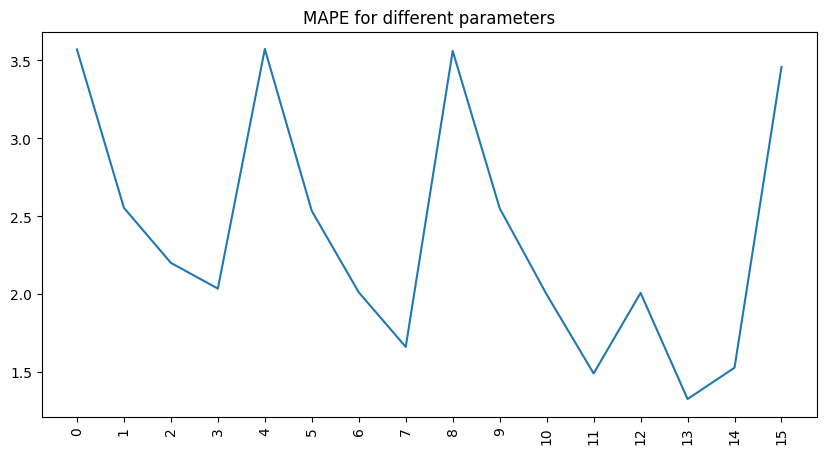

In [63]:
# plotting the mape for the different parameters
plt.figure(figsize=(10, 5))
plt.plot(tuning_results['mape'])
plt.xticks(range(len(tuning_results)), tuning_results.index, rotation=90)
plt.title('MAPE for different parameters')
plt.show()


In [64]:
# Find the best parameters
best_params = all_params[np.argmin(mapes)]
best_params

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1}

Put the best params in original model 

I tried different scenarios and the best params are always 0.5 and 0.1